In [1]:
import os

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from utils import BrainDataset

# Paths to NIfTI files
# list all files in folder data MSSEG-1
dataset_path = "../../MSSEG-1-test-preprocessed-2/"

# Create the dataset and dataloader
dataset = BrainDataset(root_dir=dataset_path)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


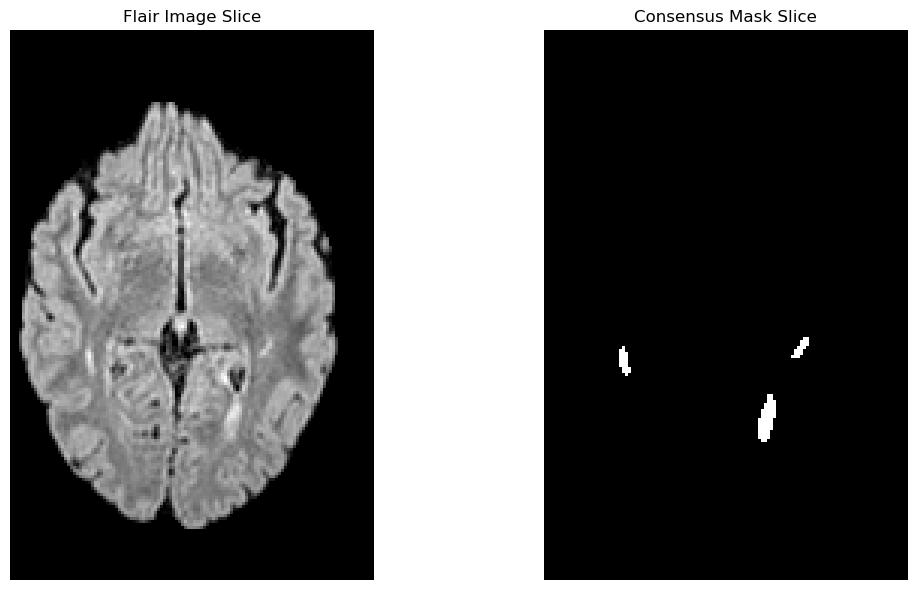

In [2]:
# Fetch a sample from the dataset
images, targets = next(iter(data_loader))

# Select the first sample
image = images[0].squeeze(0).numpy()  # Remove channel dimension
mask = targets[0]['masks'][0].numpy()  # Select the first mask

# Plot the image slice and the corresponding mask slice
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Flair Image Slice")
axes[0].axis("off")

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Consensus Mask Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [3]:
import torchvision

num_classes = 2  # Background + 1 class for segmentation

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

# Modify the classifier and mask head for the new dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(    in_features_mask, hidden_layer, num_classes)

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

In [6]:
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)

        # Check for NaNs in the loss dictionary
        for key, value in loss_dict.items():
            if torch.isnan(value).any():
                print(f"NaN detected in {key}")

        losses = sum(loss for loss in loss_dict.values())
        if torch.isnan(losses):
            print("NaN in overall loss. Skipping batch.")
            continue  # Skip this batch

        epoch_loss += losses.item()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save the model if the current epoch's loss is better than the best loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved with loss: {best_loss:.4f}")

Epoch 1/10, Loss: 10.3289
Model saved with loss: 10.3289
Epoch 2/10, Loss: 5.4212
Model saved with loss: 5.4212
Epoch 3/10, Loss: 3.4282
Model saved with loss: 3.4282
Epoch 4/10, Loss: 2.6510
Model saved with loss: 2.6510
Epoch 5/10, Loss: 1.9368
Model saved with loss: 1.9368
Epoch 6/10, Loss: 1.9277
Model saved with loss: 1.9277
Epoch 7/10, Loss: 1.5958
Model saved with loss: 1.5958
Epoch 8/10, Loss: 1.8164
Epoch 9/10, Loss: 1.4666
Model saved with loss: 1.4666
Epoch 10/10, Loss: 1.4684


/tmp/ipykernel_9759/492650950.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


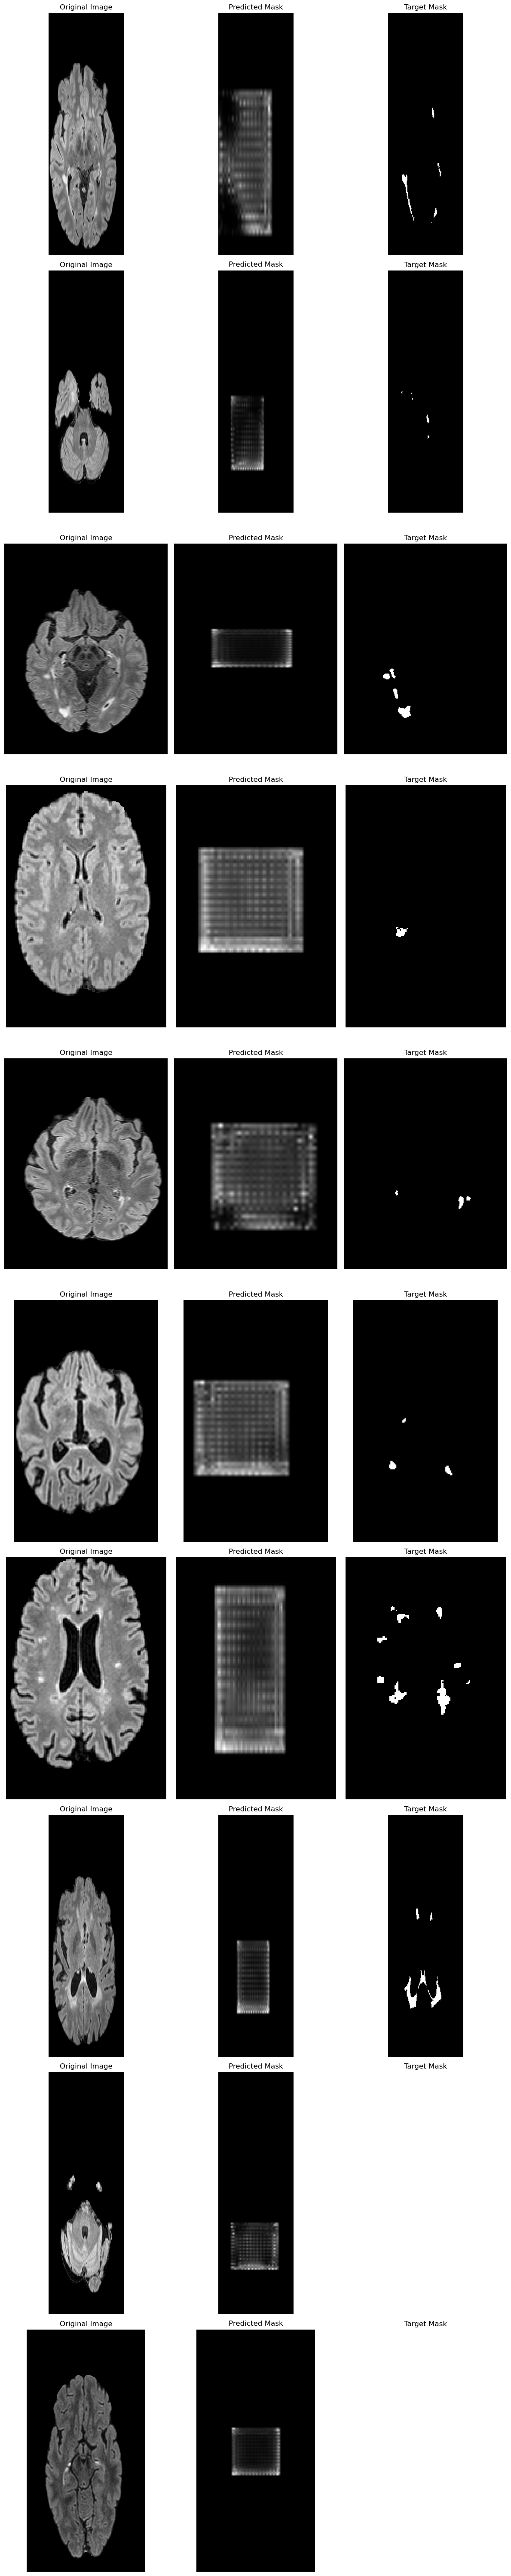

In [10]:
# Load the trained model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get a batch of images from the data loader
images, targets = next(iter(data_loader))
images = [img.to(device) for img in images]

# Make predictions using the model
with torch.no_grad():
    predictions = model(images)

# Plot the original image and the predicted mask
fig, axes = plt.subplots(len(images), 3, figsize=(12, 6 * len(images)))

for i, (image, prediction, target) in enumerate(zip(images, predictions, targets)):
    image = image.squeeze(0).cpu().numpy()  # Remove channel dimension and move to CPU
    mask = prediction['masks'][0, 0].cpu().numpy()  # Select the first predicted mask and move to CPU

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 1].axis("off")

    if len(target['masks']) > 0:
        axes[i, 2].imshow(target['masks'][0].numpy(), cmap='gray')
    axes[i, 2].set_title("Target Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()